In [2]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#plt.style.use("classic")
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from datetime import datetime
import re

import warnings
warnings.filterwarnings("ignore")


###
1. extracting stock from yf (tickers, start="2024-01-01", end="2024-12-08", interval="1d",period="1mo")
2. calculate min, max,np.mean,pd.quantile(0.25)
   diff::Calculate the change between neighboring rows
   pct_change:Calculate the percentage change between neighboring rows
   
3. How much does $1 on the first day equate to on the last day, holding yield
4. long and short-term moving average, gold and death cross

In [4]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
ticker = yf.Ticker("AAPL")
df = ticker.history(period="1mo", interval="1d")  # 获取当天的每分钟数据
df.head(20)
#df.plot(figsize=(12,12),subplots = True)

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [5]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
# 批量下载股票数据
data = yf.download(tickers, start="2024-01-01", end="2024-12-27", interval="1d")

# 提取收盘价数据
close_prices = data['Close']
close_prices.head()

#df.index = pd.to_datetime(df.index, errors='coerce')

[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-02,185.639999,149.929993,138.169998,370.869995,248.419998
2024-01-03,184.250000,148.470001,138.919998,370.600006,238.449997
2024-01-04,181.910004,144.570007,136.389999,367.940002,237.929993
2024-01-05,181.179993,145.240005,135.729996,367.750000,237.490005
2024-01-08,185.559998,149.100006,138.839996,374.690002,240.449997


In [15]:
close_prices.info()
close_prices.describe().round(2)
#close_prices.aggregate([min, max,np.mean,pd.quantile(0.25)])

#close_prices.diff().head()
#每天的增长率
close_prices.pct_change().head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2024-01-02 to 2024-12-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    236 non-null    float64
 1   AMZN    236 non-null    float64
 2   GOOGL   236 non-null    float64
 3   MSFT    236 non-null    float64
 4   TSLA    236 non-null    float64
dtypes: float64(5)
memory usage: 11.1 KB


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-02,NaN,NaN,NaN,NaN,NaN
2024-01-03,-0.007488,-0.009738,0.005428,-0.000728,-0.040134
2024-01-04,-0.012700,-0.026268,-0.018212,-0.007178,-0.002181
2024-01-05,-0.004013,0.004634,-0.004839,-0.000516,-0.001849
2024-01-08,0.024175,0.026577,0.022913,0.018872,0.012464


In [18]:
#每天的增长率
close_prices.pct_change().mean().plot(kind="bar",figsize = (10,6))


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-02,-0.007488,-0.009738,0.005428,-0.000728,-0.040134
2024-01-03,-0.012700,-0.026268,-0.018212,-0.007178,-0.002181
2024-01-04,-0.004013,0.004634,-0.004839,-0.000516,-0.001849
2024-01-05,0.024175,0.026577,0.022913,0.018872,0.012464
2024-01-08,-0.002263,0.015225,0.015197,0.002936,-0.022832


<Axes: xlabel='Date'>

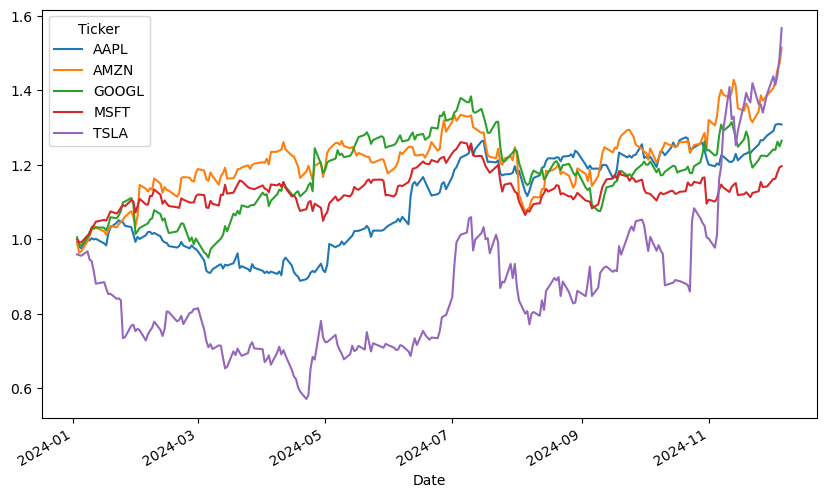

In [24]:
#How much does $1 on the first day equate to on the last day
ccon_change = np.log(close_prices/close_prices.shift(1))
ccon_change.head().round(3)
#restore
ccon_change.cumsum().apply(np.exp).plot(figsize=(10,6))

In [27]:
#close_prices.resample("1w").last().head()
close_prices.resample("1w",label = "right").last().head()

C:\Users\602599140\AppData\Local\Temp\ipykernel_8664\3254796966.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  close_prices.resample("1w").last().head()
C:\Users\602599140\AppData\Local\Temp\ipykernel_8664\3254796966.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  close_prices.resample("1w",label = "right").last().head()


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2024-01-07,181.179993,145.240005,135.729996,367.750000,237.490005
2024-01-14,185.919998,154.619995,142.649994,388.470001,218.889999
2024-01-21,191.559998,155.339996,146.380005,398.670013,212.190002
2024-01-28,192.419998,159.119995,152.190002,403.929993,183.250000
2024-02-04,185.850006,171.809998,142.380005,411.220001,187.910004


In [3]:
＃df = close_prices.dropna()
#10天为窗口滑动
windows = 10

df["AAPL"].rolling(window = windows).mean()

Date
2024-01-02           NaN
2024-01-03           NaN
2024-01-04           NaN
2024-01-05           NaN
2024-01-08           NaN
                 ...    
2024-12-02    232.346999
2024-12-03    233.809998
2024-12-04    235.282997
2024-12-05    236.686996
2024-12-06    238.118996
Name: AAPL, Length: 236, dtype: float64

In [4]:
#短均和长均
df = close_prices

df["20d"] = df["AAPL"].rolling(window = 20).mean()
df["60d"] = df["AAPL"].rolling(window = 60).mean()


C:\Users\602599140\AppData\Local\Temp\ipykernel_14072\2286771958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["20d"] = df["AAPL"].rolling(window = 20).mean()
C:\Users\602599140\AppData\Local\Temp\ipykernel_14072\2286771958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["60d"] = df["AAPL"].rolling(window = 60).mean()


In [5]:
#death cross and gold cross
df["avg_jud"]= np.where(df["20d"]>df["60d"],1,-1)
df.head()

C:\Users\602599140\AppData\Local\Temp\ipykernel_14072\1124018969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["avg_jud"]= np.where(df["20d"]>df["60d"],1,-1)


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA,20d,60d,avg_jud
Date,,,,,,,,
2024-01-02,185.639999,149.929993,138.169998,370.869995,248.419998,NaN,NaN,-1
2024-01-03,184.250000,148.470001,138.919998,370.600006,238.449997,NaN,NaN,-1
2024-01-04,181.910004,144.570007,136.389999,367.940002,237.929993,NaN,NaN,-1
2024-01-05,181.179993,145.240005,135.729996,367.750000,237.490005,NaN,NaN,-1
2024-01-08,185.559998,149.100006,138.839996,374.690002,240.449997,NaN,NaN,-1


<Axes: xlabel='Date'>

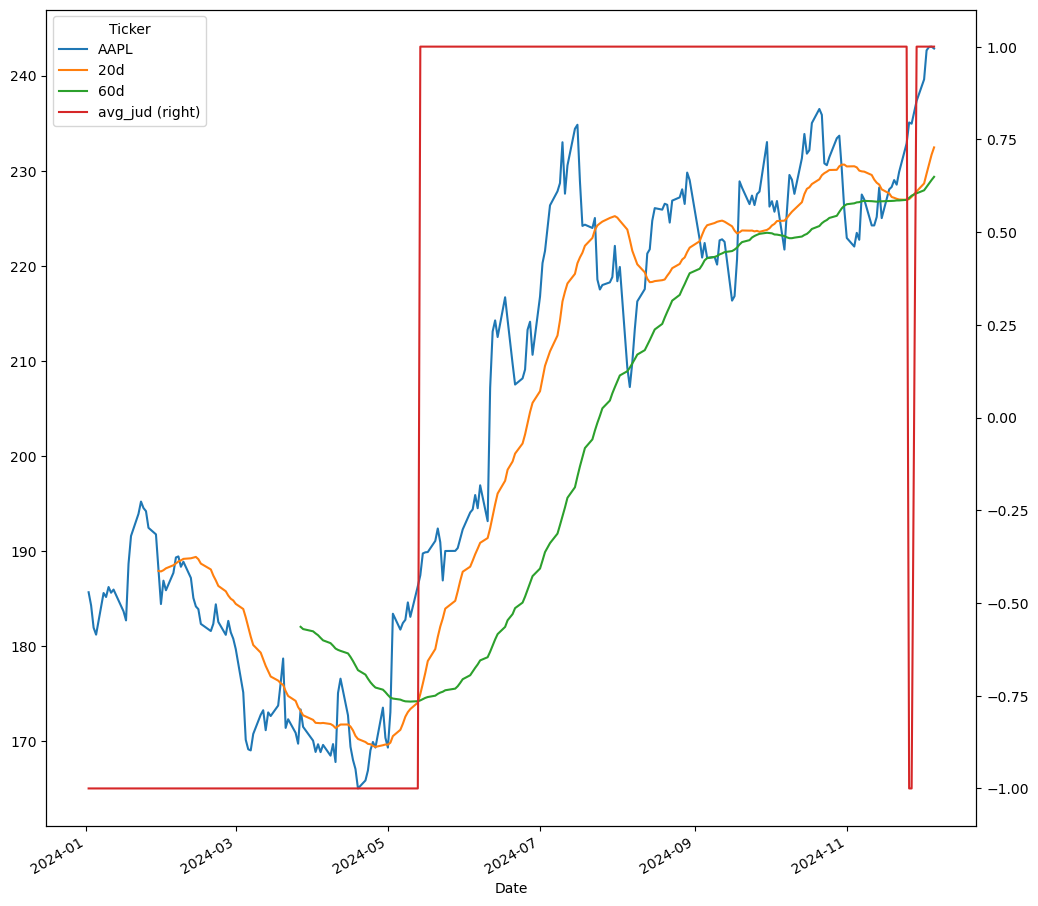

In [6]:
df[["AAPL","20d","60d"]].tail()
#df[["AAPL","20d","60d"]].plot(figsize= (12,12))
df[["AAPL","20d","60d","avg_jud"]].plot(figsize= (12,12),secondary_y = "avg_jud")

###
1. seeking relationship between two index
2. visualization
3. regression and Correlation coefficient
4. computing the change of correlation with years

In [25]:
tickers = ["^GSPC", "^VIX"]
# 批量下载股票数据
data = yf.download(tickers, start="2015-01-01", end="2024-12-08", interval="1d")

# 提取收盘价数据
df_c = data['Close']
df_c.columns = ["SPY","VIX"]
df_c.head()

[*********************100%%**********************]  2 of 2 completed


,SPY,VIX
Date,,
2015-01-02,2058.199951,17.790001
2015-01-05,2020.579956,19.920000
2015-01-06,2002.609985,21.120001
2015-01-07,2025.900024,19.309999
2015-01-08,2062.139893,17.010000


<Axes: xlabel='Date'>

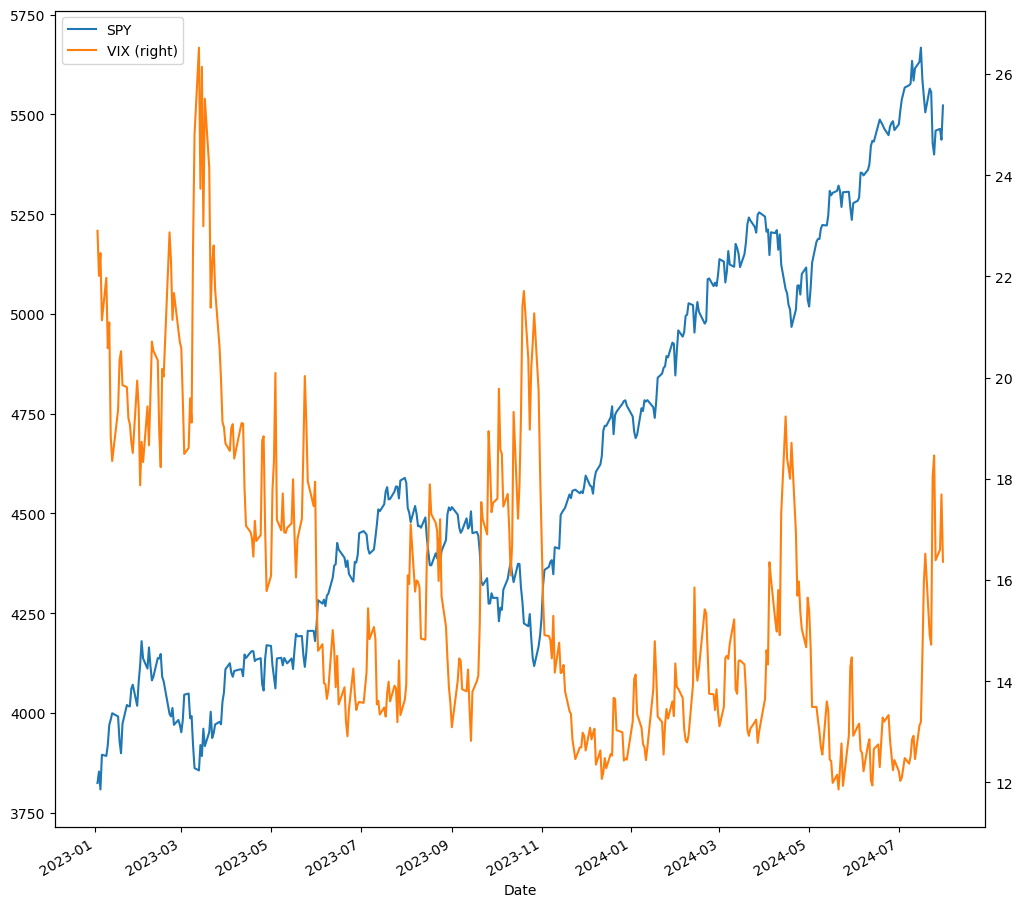

In [17]:
#visualization of relationship
df_c.loc[:'2024-07-31'].plot(figsize= (12,12),secondary_y = "VIX")

array([[<Axes: xlabel='SPY', ylabel='SPY'>,
        <Axes: xlabel='VIX', ylabel='SPY'>],
       [<Axes: xlabel='SPY', ylabel='VIX'>,
        <Axes: xlabel='VIX', ylabel='VIX'>]], dtype=object)

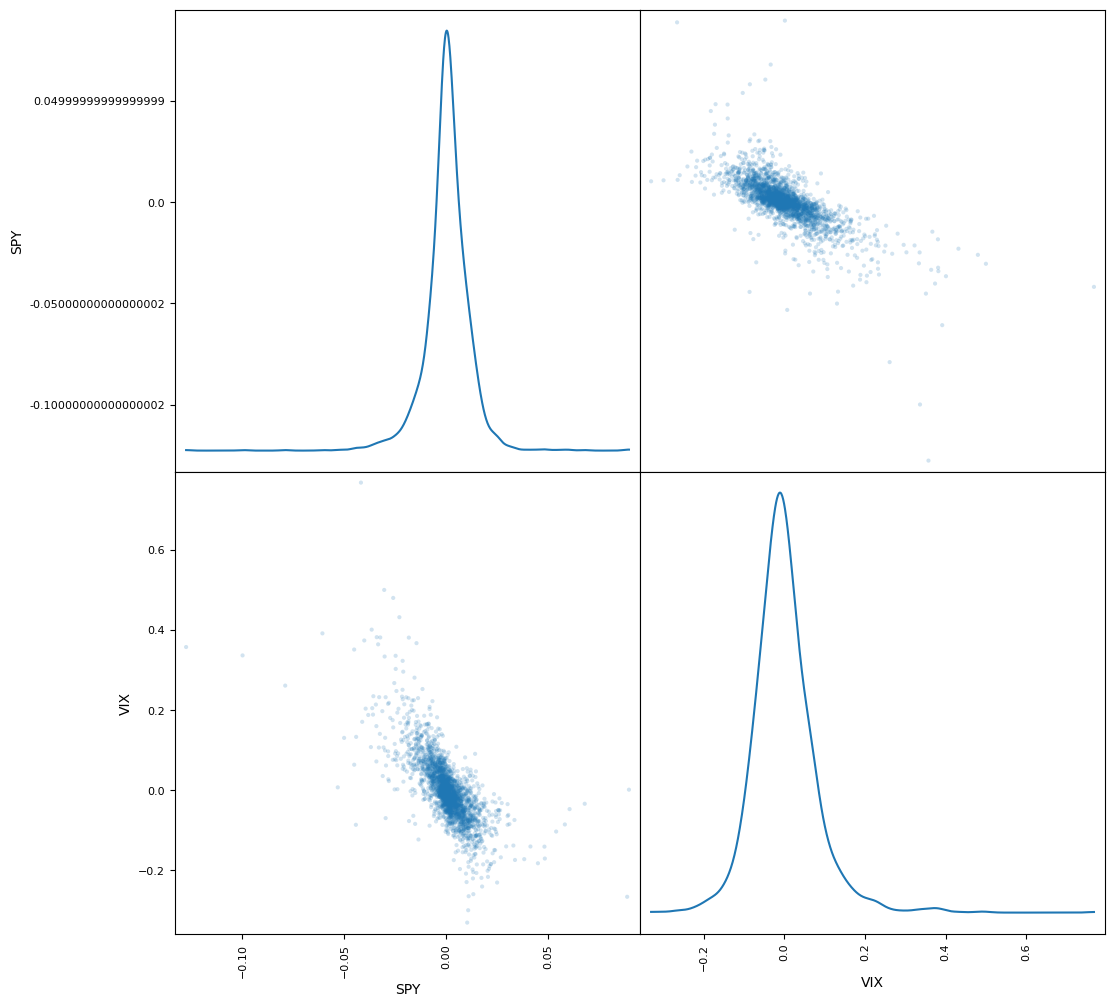

In [26]:
#to show negative relationship
grow_rate = np.log(df_c/df_c.shift(1))
grow_rate.dropna(inplace = True)
pd.plotting.scatter_matrix(grow_rate,
                           alpha = 0.2,
                           #diagonal = 'hist',
                           #hist_kwds = {'bins':50},
                           diagonal = 'kde',
                           figsize = (12,12)
                          )

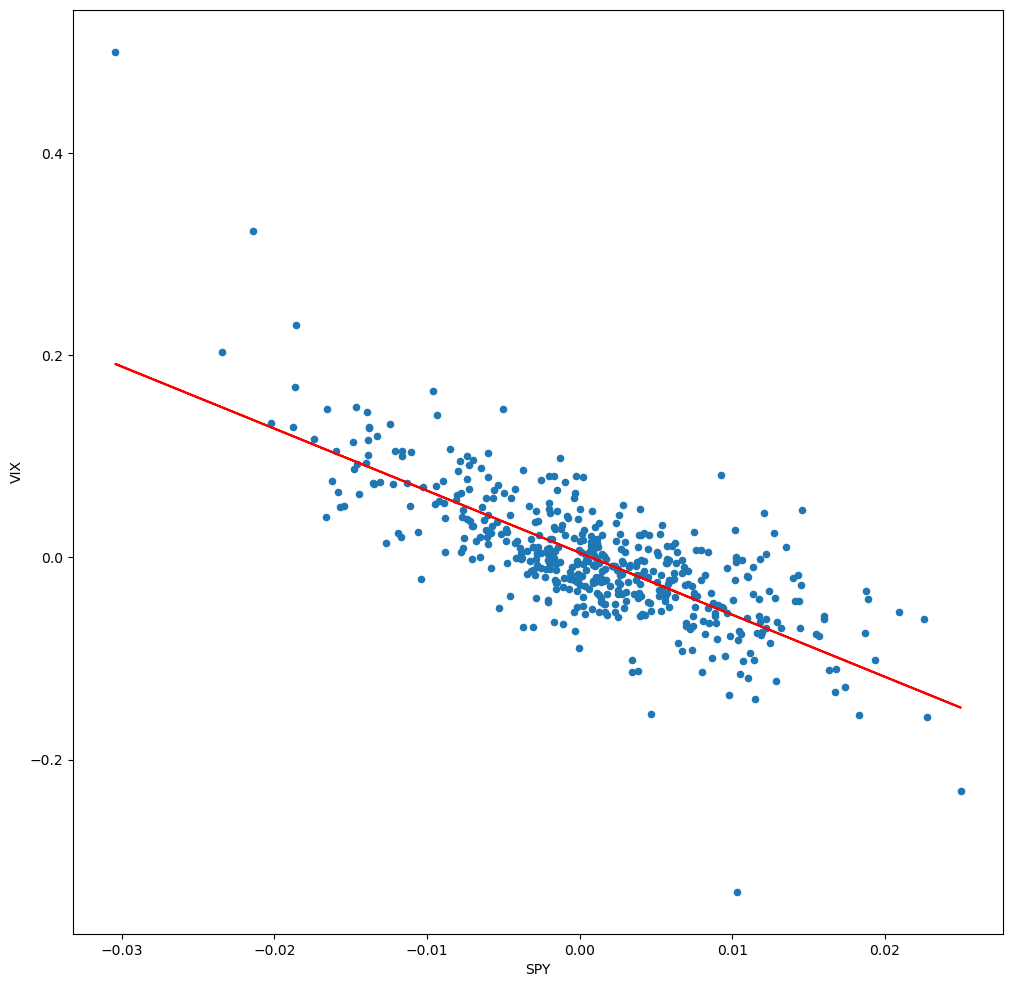

In [21]:
#built regression model para: x,y, deg:set exponent
#corelationship coefficient
regression = np.polyfit(grow_rate['SPY'],grow_rate['VIX'],deg= 1)
#grow_rate.corr()
plo = grow_rate.plot(kind='scatter',x = 'SPY',y = 'VIX',figsize = (12,12))
plo.plot(grow_rate['SPY'],np.polyval(regression,grow_rate['SPY']),'r')

<Axes: xlabel='Date'>

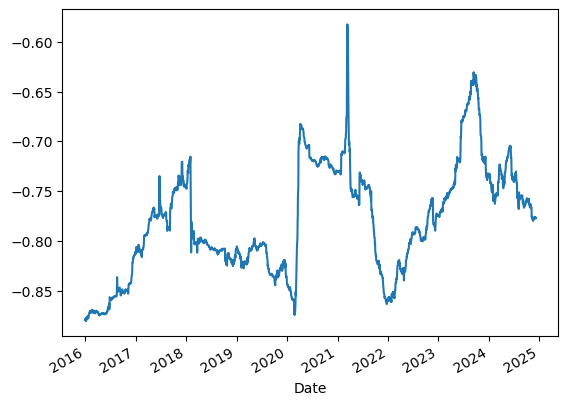

In [27]:
# computing change
grow_rate['SPY'].rolling(window = 250).corr(grow_rate['VIX']).plot()

*******TWO MA strategy*******
1. preprocessing: remove NA, check outlier
2. determining short and long
3. Execute the strategy and calculate the return

In [6]:
#preprocessing
df = close_prices[['AAPL']].dropna()

<Axes: xlabel='Date'>

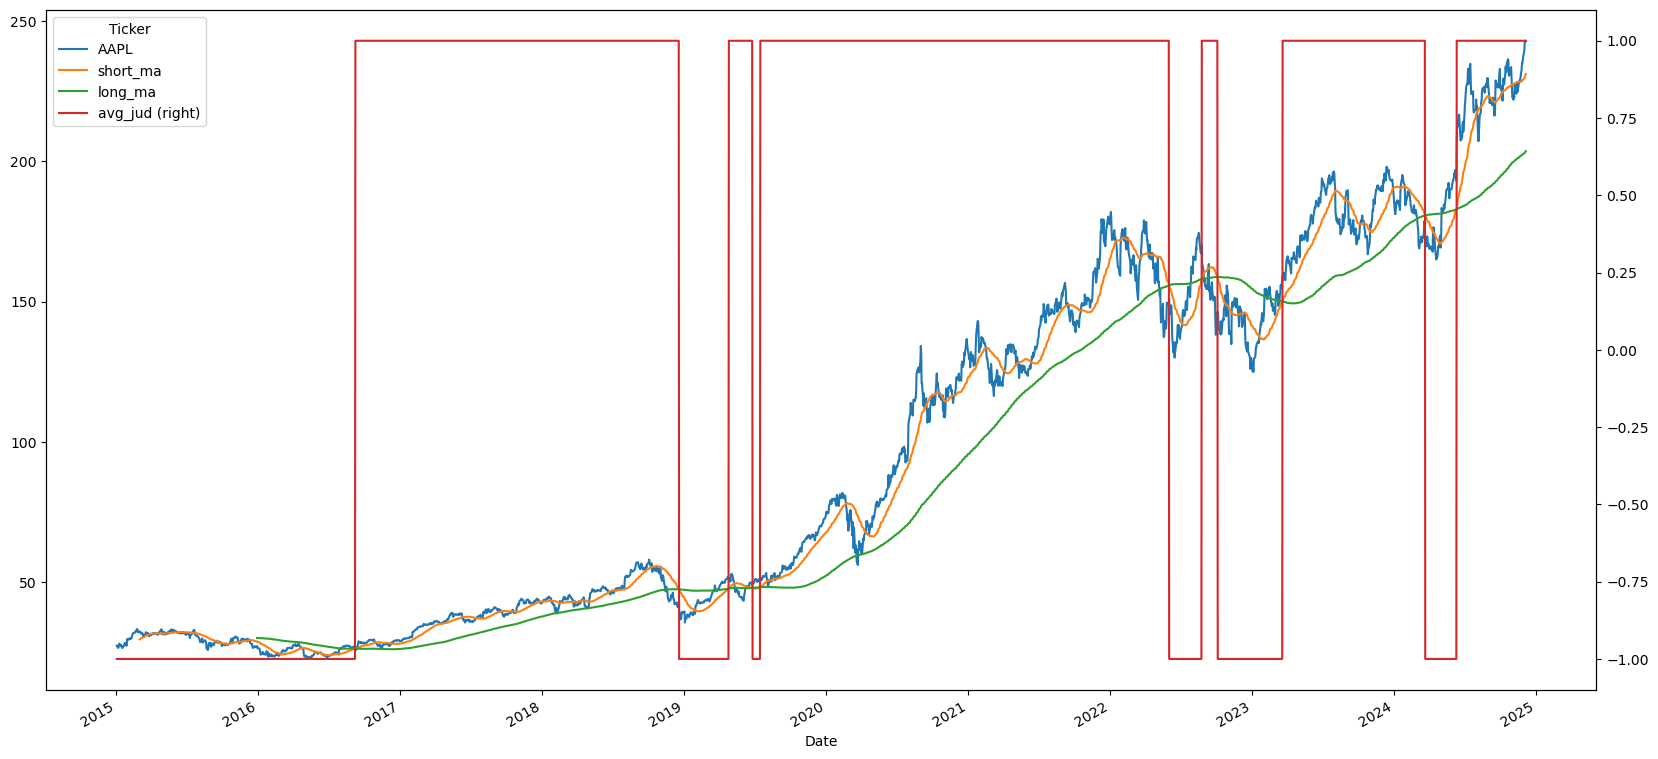

In [52]:
short_ma =40
long_ma = 250
df["short_ma"]=df['AAPL'].rolling(short_ma).mean()
df["long_ma"]=df['AAPL'].rolling(long_ma).mean()
df["avg_jud"]= np.where(df["short_ma"]>df["long_ma"],1,-1)
df[["AAPL","short_ma","long_ma","avg_jud"]].plot(figsize= (20,10),secondary_y = "avg_jud")

In [8]:
#non-strategic and strategic return
df["returns"] = np.log(df['AAPL']/df['AAPL'].shift(1))
df["st_returns"] = df['avg_jud'].shift(1)*df["returns"]
df.dropna(inplace=True)
np.exp(df[['returns','st_returns']].sum())

Ticker
returns       3.625780
st_returns    4.024199
dtype: float64

In [57]:
#Adjust parameters
from itertools import product
df = close_prices[['AAPL']].dropna()
short_ma = [20,40,60,80]
long_ma = [150,200,250,280]
res = pd.DataFrame(columns=["short_ma", "long_ma", "returns", "st_returns", "performance"])

# Traverse all combinations of (short_ma, long_ma) parameters.
for ma1, ma2 in product(short_ma, long_ma):
    if ma1 >= ma2:
        continue
    df_temp = df.copy()

    df_temp["returns"] = np.log(df_temp['AAPL'] / df_temp['AAPL'].shift(1))
    df_temp["short_ma"] = df_temp['AAPL'].rolling(ma1).mean()
    df_temp["long_ma"] = df_temp['AAPL'].rolling(ma2).mean()
    df_temp.dropna(inplace=True)
    df_temp["avg_jud"] = np.where(df_temp["short_ma"] > df_temp["long_ma"], 1, -1)
    df_temp["st_returns"] = df_temp["avg_jud"].shift(1) * df_temp["returns"]
    df_temp.dropna(inplace=True)
    performance = np.exp(df_temp[['returns', 'st_returns']].sum())

    res = pd.concat([res, pd.DataFrame({
        'short_ma': [ma1],
        'long_ma': [ma2],
        'returns': [performance['returns']],
        'st_returns': [performance['st_returns']],
        'performance': [performance['st_returns'] - performance['returns']]
    })], ignore_index=True)
print('over')

over


*******Strategy Evaluation Metrics*******
1.Annualized Return

In [6]:
df = close_prices[['AAPL']].dropna()
df_new = df/df.iloc[0]
#df_new.plot(figsize=(12,6))
returns = df_new.iloc[-1]-1
#a_return = (df.fillna(method= 'pad')).apply(lambda x:x/x.shift(1)-1)[1:]
a_return = pd.DataFrame(returns.values,columns= ['returns'],index= returns.index)

months = 12
a_return['annual_returns'] = ((1 + a_return['returns']) ** (12 / months) - 1)
v

,returns,annual_returns
Ticker,,
AAPL,0.395281,0.395281


*******Strategy Evaluation Metrics*******
2.Maximum Drawdown

In [31]:
df_md = df['2023-01-01':'2023-12-30']
df_md["Peak"] = df_md["AAPL"].cummax()
df_md['Drawdown'] = (df_md['AAPL']- df_md["Peak"])/df_md["Peak"]
max_drawdown = df_md['Drawdown'].min()
print("max drawdown:",max_drawdown)
print("occur in:",df_md['Drawdown'].idxmin())

max drawdown: -0.15047084763448376
occur in: 2023-10-26 00:00:00


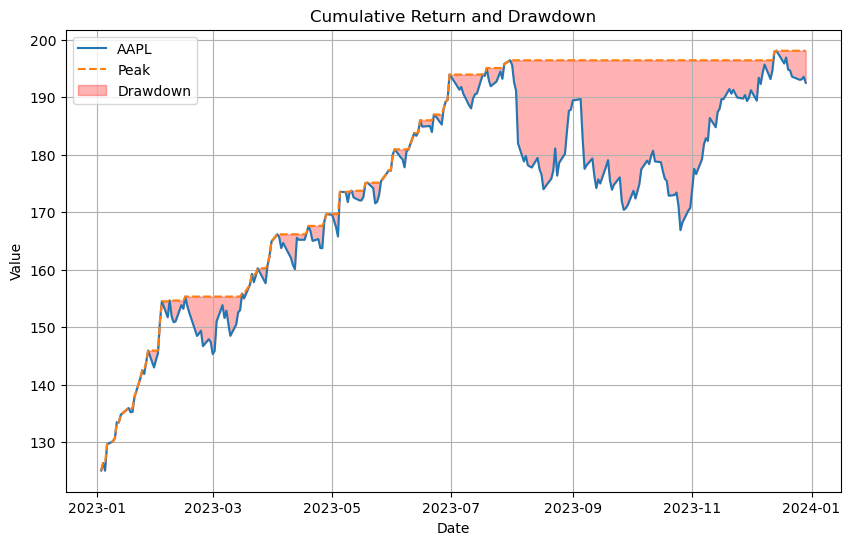

In [32]:
#drawdown curve
plt.figure(figsize=(10, 6))
plt.plot(df_md.index, df_md["AAPL"], label="AAPL")
plt.plot(df_md.index, df_md["Peak"], label="Peak", linestyle="--")
plt.fill_between(df_md.index, df_md["AAPL"], df_md["Peak"], color="red", alpha=0.3, label="Drawdown")
plt.title("Cumulative Return and Drawdown")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

*******Strategy Evaluation Metrics*******
3.Sharpe Ratio

In [ ]:
df = close_prices[['AAPL']].dropna()

In [7]:
# Get the US 10-year Treasury yield  (^TNX)
ticker = "^TNX"
ten_year_yield = yf.Ticker(ticker)
historical_data = ten_year_yield.history(start="2024-01-01", end="2024-12-27")

# computing risk free yield (R_f)
historical_data["Yield"] = historical_data["Close"] / 10  
risk_free_rate = historical_data["Yield"].mean() / 100
risk_free_rate

0.00420265461737851

*****Annualized Volatility*****
Assume that daily return fluctuations are independent and identically distributed.
The total volatility of cumulative returns increases with time, but the rate of increase is the square root of time.

In [9]:
#Annualized Volatility
df["Log Return"] = np.log(df["AAPL"] / df["AAPL"].shift(1))
df = df.dropna()
# Calculate the standard deviation of daily returns
daily_std = df["Log Return"].std()

# 4. Annualized Volatility
a_return["annual_volatility"] = daily_std * np.sqrt(252)

In [10]:

# Sharpe Ratio
a_return["sharpe_ratio"] = (a_return["annual_returns"] - risk_free_rate) / a_return["annual_volatility"]
a_return

,returns,annual_returns,annual_volatility,sharpe_ratio
Ticker,,,,
AAPL,0.395281,0.395281,0.223487,1.749894


In [13]:
# 年份列表
years = [2025, 2024, 2023, 2022]

# 存储各年数据的列表
dfs = []

for year in years:
    # 构建带年份过滤的 URL
    url = (
        "https://home.treasury.gov/resource-center/data-chart-center/"
        "interest-rates/TextView"
        f"?type=daily_treasury_yield_curve&field_tdr_date_value={year}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table")
    
    # 提取表头
    headers = [th.get_text(strip=True) for th in table.find_all("th")]
    # 提取行
    rows = []
    for tr in table.find_all("tr")[1:]:
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        if cells:
            rows.append(cells)
    
    # 转为 DataFrame
    df_year = pd.DataFrame(rows, columns=headers)
    df_year["Date"] = pd.to_datetime(df_year["Date"])
    df_year.set_index("Date", inplace=True)
    
    dfs.append(df_year)

# 合并所有年份的数据
df_all = pd.concat(dfs).sort_index()

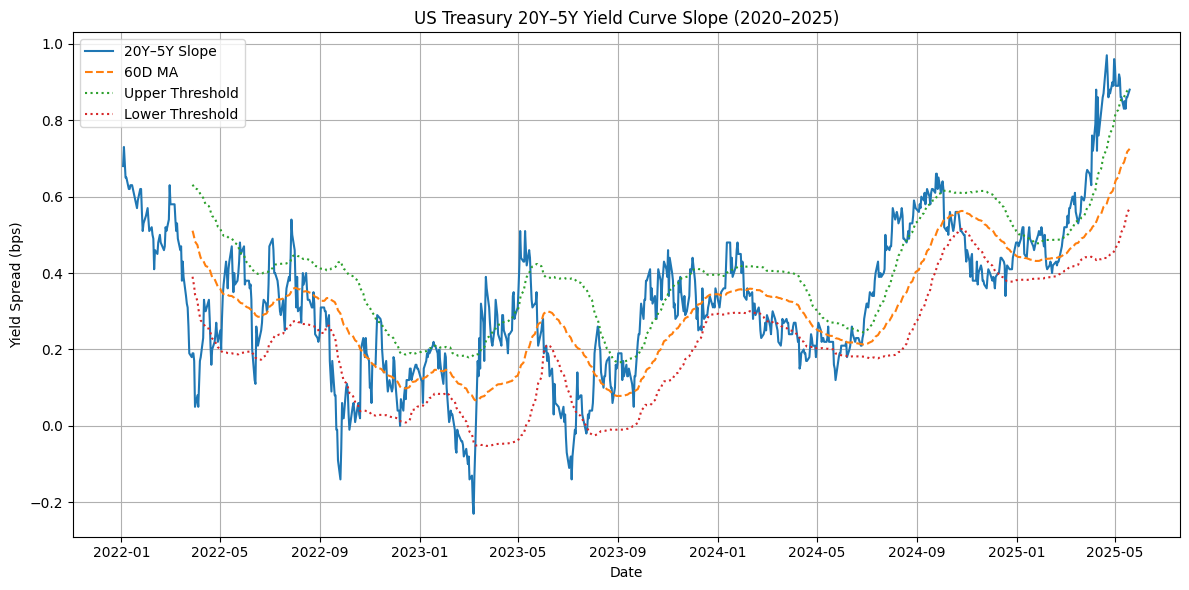

              Y5   Y20  Slope        MA     Upper     Lower  Signal
Date                                                               
2025-05-06  3.90  4.82   0.92  0.659500  0.836158  0.482842       1
2025-05-07  3.87  4.78   0.91  0.667667  0.844392  0.490942       1
2025-05-08  4.00  4.86   0.86  0.674833  0.850473  0.499194       1
2025-05-09  4.00  4.86   0.86  0.682167  0.856163  0.508170       1
2025-05-12  4.09  4.92   0.83  0.689333  0.860341  0.518326       0
2025-05-13  4.12  4.97   0.85  0.696500  0.865021  0.527979       0
2025-05-14  4.17  5.00   0.83  0.703167  0.868855  0.537479       0
2025-05-15  4.07  4.93   0.86  0.710500  0.873152  0.547848       0
2025-05-16  4.06  4.92   0.86  0.717667  0.877193  0.558140       0
2025-05-19  4.07  4.95   0.88  0.725167  0.881485  0.568848       0


In [20]:
# 提取并转换 5Y 和 20Y 列
df = df_all.rename(columns={'5 Yr': 'Y5', '20 Yr': 'Y20'})
df[['Y5', 'Y20']] = df[['Y5', 'Y20']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['Y5', 'Y20'])

# 计算 20Y-5Y 利差
df['Slope'] = df['Y20'] - df['Y5']

# 计算 60 日滚动均值和标准差，构建阈值
window = 60
df['MA'] = df['Slope'].rolling(window).mean()
df['STD'] = df['Slope'].rolling(window).std()
k = 1.0
df['Upper'] = df['MA'] + k * df['STD']
df['Lower'] = df['MA'] - k * df['STD']

# 生成交易信号
df['Signal'] = 0
df.loc[df['Slope'] > df['Upper'], 'Signal'] = 1
df.loc[df['Slope'] < df['Lower'], 'Signal'] = -1

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Slope'], label='20Y–5Y Slope')
plt.plot(df.index, df['MA'], linestyle='--', label='60D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')
plt.title('US Treasury 20Y–5Y Yield Curve Slope (2020–2025)')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 打印最近 10 条信号
print(df[['Y5', 'Y20', 'Slope', 'MA', 'Upper', 'Lower', 'Signal']].tail(10))

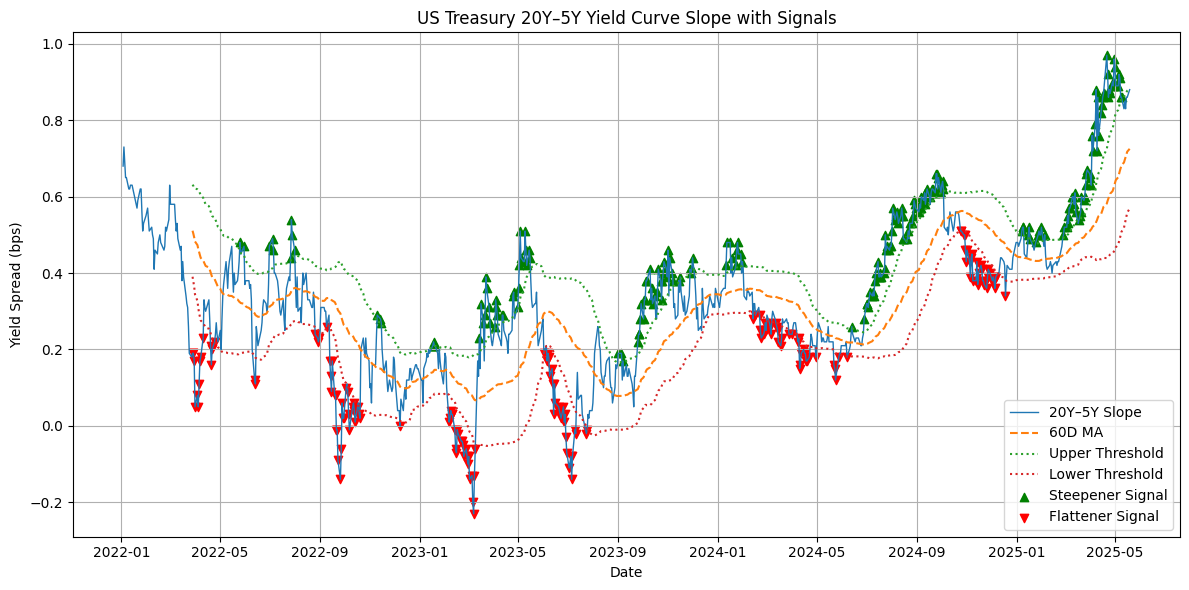

In [ ]:
# 提取并转换 5Y 和 20Y 列
df = df_all.rename(columns={'5 Yr': 'Y5', '20 Yr': 'Y20'})
df[['Y5', 'Y20']] = df[['Y5', 'Y20']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['Y5', 'Y20'])

# 计算 20Y-5Y 利差
df['Slope'] = df['Y20'] - df['Y5']
# 4. 计算滚动统计和信号
window = 60
df['MA'] = df['Slope'].rolling(window).mean()
df['STD'] = df['Slope'].rolling(window).std()
k = 1.0
df['Upper'] = df['MA'] + k * df['STD']
df['Lower'] = df['MA'] - k * df['STD']
df['Signal'] = 0
df.loc[df['Slope'] > df['Upper'], 'Signal'] = 1
df.loc[df['Slope'] < df['Lower'], 'Signal'] = -1

# 5. 可视化并标记信号
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Slope'], label='20Y–5Y Slope', linewidth=1)
plt.plot(df.index, df['MA'], linestyle='--', label='60D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')

# 标记Signal为1的点（Steepener）和Signal为-1的点（Flattener）
steep_dates = df[df['Signal'] == 1].index
flat_dates = df[df['Signal'] == -1].index
plt.scatter(steep_dates, df.loc[steep_dates, 'Slope'], marker='^', color='green', label='Steepener Signal')
plt.scatter(flat_dates, df.loc[flat_dates, 'Slope'], marker='v', color='red', label='Flattener Signal')

plt.title('US Treasury 20Y–5Y Yield Curve Slope with Signals')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# 1. 定义ETF代码和各自的久期（年）
tickers = {
    "2856.T": 5.0,   # 3–7年ETF，久期约5年
    "2621.T": 8.0    # 7–10年ETF，久期约8年
}

# 2. 获取历史价格数据
start_date = "2025-01-01"
end_date = "2025-05-20"
data = yf.download(list(tickers.keys()), start=start_date, end=end_date)["Adj Close"]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 2 completed

2 Failed downloads:
['2856.T', '2621.T']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 2 completed

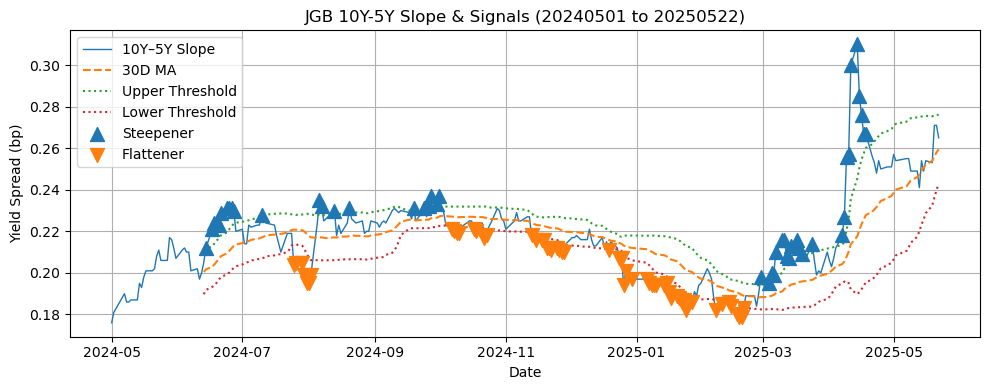

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

def fetch_jgb_yields(start, end, window=30):
# 主数据源
    url_main = "https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
    # 补充源（最近利率）
    url_extra = "https://www.mof.go.jp/jgbs/reference/interest_rate/jgbcm.csv"
    

    def load_csv(url):
            resp = requests.get(url)
            resp.encoding = 'shift_jis'
            df = pd.read_csv(StringIO(resp.text), skiprows=1)
            
            # 转换日本年号到公元日期
            def to_greg(s):
                if not isinstance(s, str):
                    return pd.NaT
                m = re.match(r'([SRH])(\d+)\.(\d+)\.(\d+)', s)
                if not m:
                    return pd.NaT
                era, y, mo, d = m.groups()
                base = {'S':1926, 'H':1989, 'R':2019}[era]
                return datetime(base + int(y) - 1, int(mo), int(d))
            
            # 应用日期转换，并设置为索引
            df['Date'] = df.iloc[:, 0].map(to_greg)
            df.set_index('Date', inplace=True)
            df.index = df.index.normalize()
            df = df[~df.index.isna()]
            return df

    # 加载、合并、去重
    df_main  = load_csv(url_main)
    df_extra = load_csv(url_extra)
    df_raw = pd.concat([df_main, df_extra])
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]

    # ✅ 排序索引，保证单调递增
    df_raw = df_raw.sort_index()
    
    # 按日期切片
    df_period = df_raw.loc[start:end]
    df_clean  = df_period.rename(columns={'8年':'Y8', '10年':'Y10'})[['Y8','Y10']].astype(float).dropna()
    
    # 计算指标
    df_clean['Slope'] = df_clean['Y10'] - df_clean['Y8']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1
    
    return df_clean

# 使用示例
start_date, end_date = '20240501', '20250522'
df = fetch_jgb_yields(start_date, end_date, window=30)

# --- 5. 可视化并标记信号 ---
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Slope'], label='10Y–5Y Slope', linewidth=1)
plt.plot(df.index, df['MA'], linestyle='--', label='30D MA')
plt.plot(df.index, df['Upper'], linestyle=':', label='Upper Threshold')
plt.plot(df.index, df['Lower'], linestyle=':', label='Lower Threshold')

# 标记策略信号：1=Steepener, -1=Flattener
steep_dates = df[df['Signal'] == 1].index
flat_dates  = df[df['Signal'] == -1].index
plt.scatter(steep_dates, df.loc[steep_dates, 'Slope'], marker='^', s=100, label='Steepener', zorder=5)
plt.scatter(flat_dates, df.loc[flat_dates, 'Slope'],   marker='v', s=100, label='Flattener',  zorder=5)

plt.title(f'JGB 10Y-5Y Slope & Signals ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Yield Spread (bp)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import plotly.graph_objects as go

# —— 假设你已经得到了 df（含 ['Slope','MA','Upper','Lower','Signal']）
# —— 以及 start_date, end_date
start_date, end_date = '20240501', '20250522'
df = fetch_jgb_yields(start_date, end_date, window=30)
# 标记信号日期
steep_dates = df[df['Signal'] == 1].index
flat_dates  = df[df['Signal'] == -1].index

# 创建 Figure
fig = go.Figure()

# 1) 绘制斜率和均线、上下轨
fig.add_trace(go.Scatter(
    x=df.index, y=df['Slope'], mode='lines', name='10Y–5Y Slope'
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['MA'], mode='lines', name='30D MA',
    line=dict(dash='dash')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Upper'], mode='lines', name='Upper Threshold',
    line=dict(dash='dot')
))
fig.add_trace(go.Scatter(
    x=df.index, y=df['Lower'], mode='lines', name='Lower Threshold',
    line=dict(dash='dot')
))

# 2) 添加 Steepener 信号点
fig.add_trace(go.Scatter(
    x=steep_dates,
    y=df.loc[steep_dates, 'Slope'],
    mode='markers',
    name='Steepener',
    marker_symbol='triangle-up',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 3) 添加 Flattener 信号点
fig.add_trace(go.Scatter(
    x=flat_dates,
    y=df.loc[flat_dates, 'Slope'],
    mode='markers',
    name='Flattener',
    marker_symbol='triangle-down',
    marker_size=10,
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Slope: %{y:.3f}<extra></extra>'
))

# 布局调整
fig.update_layout(
    title=f'JGB 10Y-5Y Slope & Signals ({start_date} to {end_date})',
    xaxis_title='Date',
    yaxis_title='Yield Spread (bp)',
    hovermode='closest'
)

# 显示交互式图表
fig.show()

In [ ]:
#导入函数部分
# --- Module 1: Data Loading ---
def fetch_jgb_yields(start, end, window=30):
# 主数据源
    url_main = "https://www.mof.go.jp/jgbs/reference/interest_rate/data/jgbcm_all.csv"
    # 补充源（最近利率）
    url_extra = "https://www.mof.go.jp/jgbs/reference/interest_rate/jgbcm.csv"
    

    def load_csv(url):
            resp = requests.get(url)
            resp.encoding = 'shift_jis'
            df = pd.read_csv(StringIO(resp.text), skiprows=1)
            
            # 转换日本年号到公元日期
            def to_greg(s):
                if not isinstance(s, str):
                    return pd.NaT
                m = re.match(r'([SRH])(\d+)\.(\d+)\.(\d+)', s)
                if not m:
                    return pd.NaT
                era, y, mo, d = m.groups()
                base = {'S':1926, 'H':1989, 'R':2019}[era]
                return datetime(base + int(y) - 1, int(mo), int(d))
            
            # 应用日期转换，并设置为索引
            df['Date'] = df.iloc[:, 0].map(to_greg)
            df.set_index('Date', inplace=True)
            df.index = df.index.normalize()
            df = df[~df.index.isna()]
            return df

    # 加载、合并、去重
    df_main  = load_csv(url_main)
    df_extra = load_csv(url_extra)
    df_raw = pd.concat([df_main, df_extra])
    df_raw = df_raw[~df_raw.index.duplicated(keep='last')]

    # ✅ 排序索引，保证单调递增
    df_raw = df_raw.sort_index()
    
    # 按日期切片
    df_period = df_raw.loc[start:end]
    df_clean  = df_period.rename(columns={'8年':'Y8', '10年':'Y10'})[['Y8','Y10']].astype(float).dropna()
    
    # 计算指标
    df_clean['Slope'] = df_clean['Y10'] - df_clean['Y8']
    df_clean['MA']    = df_clean['Slope'].rolling(window).mean()
    df_clean['STD']   = df_clean['Slope'].rolling(window).std()
    df_clean['Upper'] = df_clean['MA'] + df_clean['STD']
    df_clean['Lower'] = df_clean['MA'] - df_clean['STD']
    df_clean['Signal']= 0
    df_clean.loc[df_clean['Slope'] > df_clean['Upper'], 'Signal'] = 1
    df_clean.loc[df_clean['Slope'] < df_clean['Lower'], 'Signal'] = -1
    
    return df_clean

def fetch_etf_prices(symbols, start, end):
    """
    从 Stooq 拉取 ETF 收盘价，返回 DataFrame
    """
    def fetch(sym):
        url = f"https://stooq.com/q/d/l/?s={sym}&d1={start}&d2={end}&i=d"
        tmp = pd.read_csv(StringIO(requests.get(url).text),
                          parse_dates=['Date'], index_col='Date')
        return tmp['Close'].sort_index()
    prices = pd.DataFrame({name: fetch(sym) for name, sym in symbols.items()})
    prices.index = prices.index.normalize()
    return prices.loc[start:end].dropna()

# --- Module 2: Strategy & Backtest ---
def run_backtest(signals: pd.DataFrame,
                 prices: pd.DataFrame,
                 durations: dict,
                 position_fn,
                 intraday: bool = False,
                 stop_loss: float = None) -> pd.DataFrame:
    """
    通用回测框架，支持日内/跨日与止损逻辑：
      signals: 包含 ['Slope','MA','Signal']
      prices:  包含 ['Short','Long']
      durations: {'Short':dur_short,'Long':dur_long}
      position_fn: 策略函数(signals,prices)->Series(Position_today)
      intraday: True 时当天 Signal 当天生效；False 则 shift(1)
      stop_loss: 日内最大亏损 (e.g. 0.001 = 0.1%)
    返回含 ['Position','RawReturn','StrategyRet','Cumulative'] 的 DataFrame
    """
    # 1) 计算每日原始组合收益
    rets  = prices.pct_change().dropna()
    hedge = durations['Short'] / durations['Long']
    raw_combo = rets['Short'] - hedge * rets['Long']

    # 2) 生成当天仓位
    df = signals.copy()
    df['Position_today'] = position_fn(signals, prices)
    #日内
    if intraday:
        pos = df['Position_today'].reindex(raw_combo.index).fillna(0).astype(int)
    #跨日
    else:
        pos = df['Position_today'].shift(1).reindex(raw_combo.index).fillna(0).astype(int)

    # 3) 计算策略当天收益，并只对亏损部分止损
    bt = pd.DataFrame({
        'Position':   pos,
        'RawReturn':  raw_combo
    })
    bt['StrategyRet'] = bt['Position'] * bt['RawReturn']
    if stop_loss is not None:
        # 亏损时下限截断到 -stop_loss
        bt['StrategyRet'] = bt['StrategyRet'].clip(lower=-stop_loss)

    # 4) 累计净值
    bt['Cumulative'] = (1 + bt['StrategyRet']).cumprod()
    return bt
# --- Module 3: Visualization ---
def plot_results(bt, output_csv=None):
    """
    在净值曲线上标记 Steepener/Flattener 进入与退出
    """
    df = bt.copy()
    df['PrevPos'] = df['Position'].shift(1).fillna(0)

    # Identify entry and exit points
    entries_steep = df[(df['PrevPos']==0) & (df['Position']==1)]
    entries_flat  = df[(df['PrevPos']==0) & (df['Position']==-1)]
    exits         = df[(df['PrevPos']!=0) & (df['Position']==0)]

    # Calculate total PnL and cumulative return
    total_pnl = df['StrategyRet'].sum()
    cumulative_return_pct = (df['Cumulative'].iloc[-1] - 1) * 100

    # Plot equity curve and markers
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Cumulative'], label='Equity Curve', color='blue')
    plt.scatter(entries_steep.index, entries_steep['Cumulative'],
                marker='^', color='green', s=80, label='Entry Steepener')
    plt.scatter(entries_flat.index, entries_flat['Cumulative'],
                marker='^', color='red', s=80, label='Entry Flattener')
    plt.scatter(exits.index, exits['Cumulative'],
                marker='v', color='gray', s=80, label='Exit')

    # Annotation box at top-right
    plt.text(0.75, 0.95,
             f"Total PnL: {total_pnl:.4f}\n"
             f"Cumulative Return: {cumulative_return_pct:.2f}%",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.title('Strategy Equity with Entry/Exit Points')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Equity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Prepare daily PnL table
    pnl_table = df[['Position', 'StrategyRet']].copy()
    pnl_table['StrategyRet'] = pnl_table['StrategyRet'].round(6)

    # Output or save
    if output_csv:
        pnl_table.to_csv(output_csv, float_format='%.6f')
        print(f"Daily PnL saved to {output_csv}")
    else:
        print("Daily PnL:")
        #print(pnl_table)
        print("cumulative return is:",cumulative_return_pct)

# --- Main Execution ---
if __name__ == "__main__":
    start_date, end_date = '20240501', '20250520'
    # 1. JGB 斜率信号
    #signals = fetch_jgb_yields(start_date, end_date, window=30)
    # 2. ETF 价格
    #symbols = {'Short':'236a.jp', 'Long':'2561.jp'}
    #prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
    #durations = {'Short': 8.2, 'Long': 10.85}
    #bt = run_backtest(signals, prices, durations)
    # 4. 可视化
    #plot_results(bt, output_csv=None)



In [85]:
signals.head(5)

,Y8,Y10,Slope,MA,STD,Upper,Lower,Signal
Date,,,,,,,,
2024-09-02,0.712,0.936,0.224,NaN,NaN,NaN,NaN,0
2024-09-03,0.730,0.952,0.222,NaN,NaN,NaN,NaN,0
2024-09-04,0.693,0.917,0.224,NaN,NaN,NaN,NaN,0
2024-09-05,0.679,0.904,0.225,NaN,NaN,NaN,NaN,0
2024-09-06,0.656,0.880,0.224,NaN,NaN,NaN,NaN,0


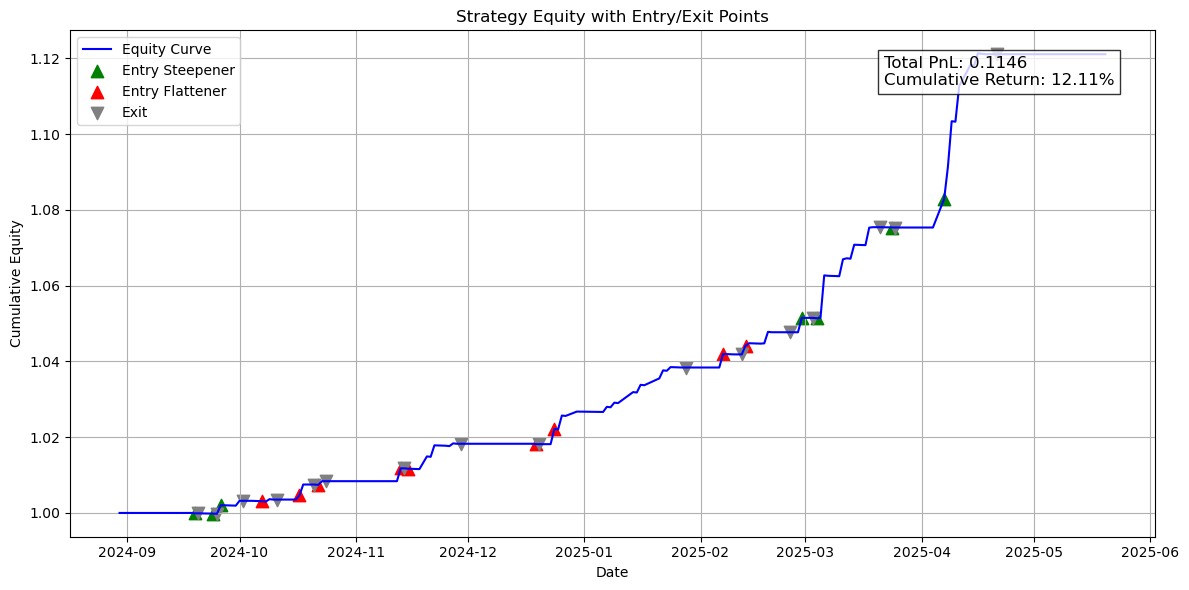

Daily PnL:
cumulative return is: 12.111537662607063


In [121]:
#日内策略 只在跌破止损平仓
def strat_intraday_signal(signals, prices):
    return signals['Signal'].reindex(prices.index).fillna(0).astype(int)

start_date, end_date = '20240501', '20250520'
signals = fetch_jgb_yields(start_date, end_date, window=30)
# 2. ETF 价格
symbols = {'Short':'236a.jp', 'Long':'2561.jp'}
prices = fetch_etf_prices(symbols, start_date, end_date)
    # 3. 回测
durations = {'Short': 8.2, 'Long': 10.73}
bt = run_backtest(
    signals, prices, durations,
    position_fn=strat_intraday_signal,
    intraday=True,
    stop_loss=0.0001   # 0.01% 日内止损
)
plot_results(bt)

In [110]:
bt.head(50)
#bt.iloc[45:100]
#bt.iloc[100:150]

,Position,RawReturn,StrategyRet,Cumulative
Date,,,,
2024-09-03,0,-0.000005,-0.000000,1.000000
2024-09-04,0,-0.000153,-0.000000,1.000000
2024-09-05,0,-0.000994,-0.000000,1.000000
2024-09-06,0,-0.000028,-0.000000,1.000000
2024-09-09,0,-0.000255,-0.000000,1.000000
2024-09-10,0,0.001073,0.000000,1.000000
2024-09-11,0,0.001369,0.000000,1.000000
2024-09-12,0,-0.001035,-0.000000,1.000000
2024-09-13,0,-0.001426,-0.000000,1.000000


In [66]:
bt7.head(50)
#bt7.iloc[45:100]
#bt7.iloc[100:150]

,Position,Short,Long,StrategyRet,Cumulative
Date,,,,,
2024-09-03,0.0,-0.001602,-0.002112,-0.000000,1.000000
2024-09-04,0.0,0.002406,0.003387,-0.000000,1.000000
2024-09-05,0.0,0.000600,0.002110,-0.000000,1.000000
2024-09-06,0.0,0.002199,0.002947,-0.000000,1.000000
2024-09-09,0.0,-0.002793,-0.003359,-0.000000,1.000000
2024-09-10,0.0,-0.000200,-0.001685,0.000000,1.000000
2024-09-11,0.0,0.003601,0.002954,0.000000,1.000000
2024-09-12,0.0,-0.000399,0.000841,-0.000000,1.000000
2024-09-13,0.0,0.000798,0.002942,-0.000000,1.000000


In [41]:
def strat1_with_stop_debug(signals, prices, durations, stop_loss=0.2):
    pos = 0
    entry_val = 0.0
    hedge = durations['Short']/durations['Long']
    for dt, row in signals.iterrows():
        sig, slope, ma = row['Signal'], row['Slope'], row['MA']
        if dt in prices.index:
            value = prices.at[dt,'Short'] - hedge*prices.at[dt,'Long']
        else:
            continue

        if pos == 0:
            if sig != 0:
                pos = sig
                entry_val = value
                print(f"{dt} 入场，entry_val={entry_val:.6f}")
        else:
            # 判断MA平仓
            if pos==1 and slope <= ma:
                print(f"{dt} 平仓(斜率回落): slope={slope:.6f}, ma={ma:.6f}")
                pos = 0
            # 判断止损
            elif pos== -1 and slope >= ma:
                print(f"{dt} 平仓(斜率回落): slope={slope:.6f}, ma={ma:.6f}")
                pos = 0
            elif value < entry_val*(1-stop_loss):
                print(f"{dt} 平仓(止损): value={value:.6f}, 阈值={entry_val*(1-stop_loss):.6f}")
                pos = 0

bt_t = run_backtest(signals, prices, durations,lambda s, p: strat1_with_stop_debug(s, p, durations, stop_loss=0.01))
#plot_results(bt_t)

2024-10-17 00:00:00 入场，entry_val=-1278.548387
2024-10-18 00:00:00 平仓(止损): value=-1282.927189, 阈值=-1265.762903
2024-10-22 00:00:00 入场，entry_val=-1273.302304
2024-10-23 00:00:00 平仓(止损): value=-1275.569585, 阈值=-1260.569281
2024-11-13 00:00:00 入场，entry_val=-1270.767742
2024-11-14 00:00:00 平仓(止损): value=-1263.098618, 阈值=-1258.060065
2024-11-15 00:00:00 入场，entry_val=-1261.642857
2024-11-18 00:00:00 平仓(止损): value=-1260.987097, 阈值=-1249.026429
2024-11-19 00:00:00 入场，entry_val=-1262.998618
2024-11-20 00:00:00 平仓(止损): value=-1266.777419, 阈值=-1250.368631
2024-11-21 00:00:00 入场，entry_val=-1263.498618
2024-11-22 00:00:00 平仓(止损): value=-1268.533180, 阈值=-1250.863631
2024-11-25 00:00:00 入场，entry_val=-1267.233180
2024-11-26 00:00:00 平仓(止损): value=-1269.556221, 阈值=-1254.560848
2024-11-27 00:00:00 入场，entry_val=-1267.533180
2024-11-28 00:00:00 平仓(止损): value=-1268.700461, 阈值=-1254.857848
2024-12-19 00:00:00 入场，entry_val=-1265.265899
2024-12-20 00:00:00 平仓(止损): value=-1271.423502, 阈值=-1252.613240
2024-12-24


Stop-loss Scan Results:
 stop_loss  total_return  max_drawdown  win_rate  pl_ratio
     0.005      0.058013     -0.010796      0.04 18.328408
     0.010      0.066965     -0.010796      0.00       NaN
     0.015      0.066965     -0.010796      0.00       NaN
     0.020      0.066965     -0.010796      0.00       NaN
     0.025      0.066965     -0.010796      0.00       NaN
     0.030      0.066965     -0.010796      0.00       NaN
     0.035      0.065813     -0.009970      0.00       NaN
     0.040      0.065813     -0.009970      0.00       NaN
     0.045      0.065813     -0.009970      0.00       NaN
     0.050      0.065813     -0.009970      0.00       NaN


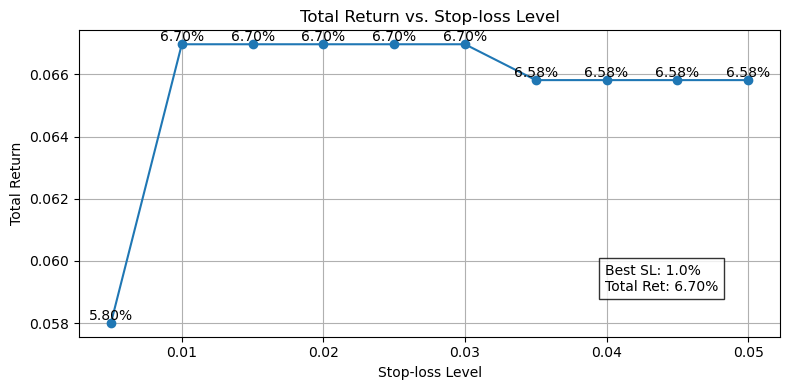

In [ ]:
#筛选止损

# --- 1. 基本配置 ---
start, end = '2024-09-01', '2025-05-20'
symbols   = {'Short':'236a.jp', 'Long':'2561.jp'}
durations = {'Short':8.2, 'Long':10.85}

# 拉信号和价格
signals = fetch_jgb_yields(start, end, window=30)
prices  = fetch_etf_prices(symbols, start.replace('-',''), end.replace('-',''))

# --- 2. 参数扫描 ---
results = []
for sl in np.arange(0.005, 0.051, 0.005):
    # 用 strat4，这里需要把 strat4 包装成 position_fn
    position_fn = lambda s,p,sl=sl: strat4(s, p, durations, stop_loss=sl)
    bt = run_backtest(signals, prices, durations, position_fn)

    # 计算指标
    total_ret = bt['Cumulative'].iloc[-1] - 1
    mdd       = max_drawdown(bt['Cumulative'])
    win_rate, pl_ratio = analyze_trades(bt)

    results.append({
        'stop_loss':   sl,
        'total_return':total_ret,
        'max_drawdown':mdd,
        'win_rate':    win_rate,
        'pl_ratio':    pl_ratio
    })

res_df = pd.DataFrame(results)

# --- 3. 输出表格 ---
print("\nStop-loss Scan Results:")
print(res_df.to_string(index=False))

# --- 4. 可视化：Total Return vs Stop-loss Level ---
plt.figure(figsize=(8,4))
plt.plot(res_df['stop_loss'], res_df['total_return'], marker='o', linestyle='-')
for sl, tr in zip(res_df['stop_loss'], res_df['total_return']):
    plt.text(sl, tr, f"{tr:.2%}", ha='center', va='bottom')

best = res_df.loc[res_df['total_return'].idxmax()]
plt.text(0.75, 0.15,
         f"Best SL: {best.stop_loss:.1%}\nTotal Ret: {best.total_return:.2%}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.title('Total Return vs. Stop-loss Level')
plt.xlabel('Stop-loss Level')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
    """
    通过累加 StrategyRet 计算每笔交易的真实收益率：
      entry_date, exit_date, return, win (1=盈利, 0=亏损)
    bt: 包含 ['Position','StrategyRet'] 的 DataFrame
    """
def extract_trades(bt: pd.DataFrame) -> pd.DataFrame:
    """
    通过累加 StrategyRet 计算每笔交易的真实收益率：
      entry_date, exit_date, return, win (1=盈利, 0=亏损)
    bt: 包含 ['Position','StrategyRet'] 的 DataFrame
    """
    trades = []
    pos = 0
    entry_date = None

    # 遍历每一天
    for date, row in bt.iterrows():
        # 开仓
        if pos == 0 and row['Position'] != 0:
            pos = row['Position']
            entry_date = date

        # 平仓
        elif pos != 0 and row['Position'] == 0:
            exit_date = date
            # 真实回报 = 这笔交易期间 StrategyRet 的累积乘积减 1
            period = bt.loc[entry_date:exit_date, 'StrategyRet'] + 1
            ret = period.prod() - 1
            trades.append({
                'entry_date': entry_date,
                'exit_date':  exit_date,
                'return':     ret,
                'win':        int(ret > 0)
            })
            pos = 0
            entry_date = None

    # 期末强制平仓
    if pos != 0 and entry_date is not None:
        exit_date = bt.index[-1]
        period = bt.loc[entry_date:exit_date, 'StrategyRet'] + 1
        ret = period.prod() - 1
        trades.append({
            'entry_date': entry_date,
            'exit_date':  exit_date,
            'return':     ret,
            'win':        int(ret > 0)
        })

    return pd.DataFrame(trades)

# —— 使用示例 ——  
trade_df = extract_trades(bt6)  
print("交易明细：")  
print(trade_df.to_string(index=False))  
win_rate = trade_df['win'].mean()  
print(f"\n重新计算胜率：{win_rate:.2%}")  
# 计算盈亏比（平均盈利 / 平均亏损）  
wins    = trade_df.loc[trade_df['win']==1, 'return']  
losses  = trade_df.loc[trade_df['win']==0, 'return']  
# 如果没有亏损或没有盈利，要做边界处理  
if not wins.empty and not losses.empty:  
    pl_ratio = wins.mean() / -losses.mean()  
elif wins.empty:  
    pl_ratio = 0.0  
else:  
    pl_ratio = float('inf')

print(f"Win Rate:    {win_rate:.2%}")  
print(f"P/L Ratio:   {pl_ratio:.2f}")  


交易明细：
entry_date  exit_date    return  win
2024-10-17 2024-10-18  0.001122    1
2024-10-22 2024-10-23 -0.002603    0
2024-11-13 2024-11-14  0.003369    1
2024-11-15 2024-11-18 -0.001740    0
2024-11-19 2024-11-20  0.001660    1
2024-11-21 2024-11-22 -0.000611    0
2024-11-25 2024-11-26 -0.002632    0
2024-11-27 2024-11-28  0.000722    1
2024-12-19 2024-12-20 -0.000366    0
2024-12-24 2024-12-25  0.003911    1
2024-12-26 2024-12-27  0.003586    1
2024-12-30 2025-01-06  0.001135    1
2025-01-07 2025-01-08  0.001300    1
2025-01-09 2025-01-10  0.001180    1
2025-01-14 2025-01-15  0.002849    1
2025-01-16 2025-01-17  0.001928    1
2025-01-20 2025-01-21  0.001308    1
2025-01-22 2025-01-23  0.002042    1
2025-01-24 2025-01-27  0.000946    1
2025-02-07 2025-02-10  0.003414    1
2025-02-13 2025-02-14  0.002229    1
2025-02-17 2025-02-18 -0.001135    0
2025-02-19 2025-02-20  0.002909    1
2025-02-28 2025-03-03  0.003606    1
2025-03-04 2025-03-05 -0.000667    0
2025-03-06 2025-03-07  0.010551 